## Tensorflow training 1D potential example


Since this is a bit more advanced than the sklearn we recommend you start the other one first

In [1]:
"""First we import our dataset examples"""
from MLTSA_datasets.OneD_pot.OneD_pot_data import potentials
from MLTSA_datasets.OneD_pot.OneD_pot_data import dataset
import matplotlib.pyplot as plt
import numpy as np

#This sets the potentials, don't re-run
total_n_pots = 25
n_DW = 5
relevant_DW_n = 2
#After defining the desired parameters we define the potentials accordingly
pots = potentials(total_n_pots, n_DW, relevant_DW_n)
# This creates the first dataset of data.
# It creates the mixing coefficients don't re-run
n_features = 180
degree_of_mixing = 2
#We specified the number of features wanted and how much they will mix
oneD_dataset = dataset(pots, n_features, degree_of_mixing)


Defining Potentials: 100%|###########################################################| 25/25 [00:00<00:00, 1044.59it/s]


This has set up our dataset for further use, since TensorFlow is more scalable and compatible with GPU calculations, we will do a more extensive search on this example. 

Let's generate the actual linear mixed data we will use for training.   


In [2]:
#Generate the trajectories
n_simulations = 100
n_steps = 500
data, ans = oneD_dataset.generate_linear(n_simulations, n_steps)
data_val, ans_val = oneD_dataset.generate_linear(int(n_simulations/2), n_steps)

#Prepare it for training
time_frame = [30, 60] #Same time frame as the sklearn one
X, Y = oneD_dataset.PrepareData(data, ans, time_frame, mode="Normal")
X_val, Y_val = oneD_dataset.PrepareData(data_val, ans_val, time_frame, mode="Normal")

Generating dataset


Running Simulations: 100%|###########################################################| 100/100 [00:28<00:00,  3.54it/s]


Getting simulation labels for the generated data


Classifying Simulation Outcomes: 100%|############################################| 100/100 [00:00<00:00, 99793.10it/s]


Generating dataset


Running Simulations: 100%|#############################################################| 50/50 [00:17<00:00,  2.93it/s]


Getting simulation labels for the generated data


Classifying Simulation Outcomes: 100%|##############################################| 50/50 [00:00<00:00, 43818.47it/s]


Now this data is generated as (X/Features, Y/labels) but those labels are strings which TensorFlow cannot handle as easy. Let's encode them for our Neural Network. 

In [3]:
#We will convert IN and OUT to numerical labels
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(len(Y), 1)).toarray()
Y_val = encoder.fit_transform(Y_val.reshape(len(Y_val),1)).toarray()
print(Y[:3])
print(Y_val[:3])

[[0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]]



Now that we have got the X and Y ready to fit to, we will train the model, in this example we want to train a Multi-Layer Perceptron just like the one in Sklearn, but we will use TensorFlow instead. For this we will have to build the models first using the build_MLP function under the MLTSA_tensorflow integrated package. This will print a summay of our model to check that the dimensions and size for each layer are correct. 


In [4]:
#We will start with the basic Multi-Layer Perceptron
from MLTSA_tensorflow import TF_2_MLP

MLP = TF_2_MLP.build_MLP(n_steps, n_features, n_labels=2).model

Building Simple MLP
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               18100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 28,402
Trainable params: 28,402
Non-trainable params: 0
_________________________________________________________________
None


Now let's put to train the MLP, in this case we can make use of the fit() function of our model and call the data (X,Y) directly without any other preparation. We will use X_val and Y_val later for further validation. 

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

#In this training we implement the same methodology as in the paper by using early stopping and a maximum of 500 iterations. 
train_log = MLP.fit(X, Y, epochs=500, batch_size=n_steps, verbose=1, validation_split=0.2,
        callbacks=[EarlyStopping(monitor='accuracy', min_delta=1e-8, restore_best_weights=True, patience=100)])

#We use now the X_val and Y_val to evaluate the quality of the training. 
val_acc = MLP.evaluate(X_val, Y_val, verbose=1)

Epoch 1/500
5/5 [==============================] - 1s 108ms/step - loss: 0.7210 - accuracy: 0.5092 - val_loss: 0.7188 - val_accuracy: 0.4000
Epoch 2/500
5/5 [==============================] - 0s 19ms/step - loss: 0.7020 - accuracy: 0.4950 - val_loss: 0.6941 - val_accuracy: 0.4000
Epoch 3/500
5/5 [==============================] - 0s 19ms/step - loss: 0.6913 - accuracy: 0.5204 - val_loss: 0.6776 - val_accuracy: 0.6000
Epoch 4/500
5/5 [==============================] - 0s 19ms/step - loss: 0.6972 - accuracy: 0.5138 - val_loss: 0.6865 - val_accuracy: 0.6000
Epoch 5/500
5/5 [==============================] - 0s 17ms/step - loss: 0.6942 - accuracy: 0.5004 - val_loss: 0.6882 - val_accuracy: 0.6000
Epoch 6/500
5/5 [==============================] - 0s 20ms/step - loss: 0.6942 - accuracy: 0.5083 - val_loss: 0.6849 - val_accuracy: 0.6000
Epoch 7/500
5/5 [==============================] - 0s 16ms/step - loss: 0.6934 - accuracy: 0.5175 - val_loss: 0.6813 - val_accuracy: 0.6000
Epoch 8/500
5/5 [==

5/5 [==============================] - 0s 18ms/step - loss: 0.6301 - accuracy: 0.7154 - val_loss: 0.6184 - val_accuracy: 0.6400
Epoch 60/500
5/5 [==============================] - 0s 19ms/step - loss: 0.6246 - accuracy: 0.7233 - val_loss: 0.6239 - val_accuracy: 0.8617
Epoch 61/500
5/5 [==============================] - 0s 19ms/step - loss: 0.6155 - accuracy: 0.7525 - val_loss: 0.6021 - val_accuracy: 0.6467
Epoch 62/500
5/5 [==============================] - 0s 19ms/step - loss: 0.6102 - accuracy: 0.7412 - val_loss: 0.6171 - val_accuracy: 0.8783
Epoch 63/500
5/5 [==============================] - 0s 19ms/step - loss: 0.5999 - accuracy: 0.7812 - val_loss: 0.5942 - val_accuracy: 0.6283
Epoch 64/500
5/5 [==============================] - 0s 21ms/step - loss: 0.5933 - accuracy: 0.7517 - val_loss: 0.5931 - val_accuracy: 0.9000
Epoch 65/500
5/5 [==============================] - 0s 19ms/step - loss: 0.6025 - accuracy: 0.6946 - val_loss: 0.6014 - val_accuracy: 0.6133
Epoch 66/500
5/5 [========

5/5 [==============================] - 0s 17ms/step - loss: 0.3290 - accuracy: 0.8733 - val_loss: 0.3561 - val_accuracy: 0.9067
Epoch 117/500
5/5 [==============================] - 0s 17ms/step - loss: 0.3353 - accuracy: 0.8658 - val_loss: 0.3983 - val_accuracy: 0.7750
Epoch 118/500
5/5 [==============================] - 0s 20ms/step - loss: 0.3464 - accuracy: 0.8358 - val_loss: 0.3668 - val_accuracy: 0.7650
Epoch 119/500
5/5 [==============================] - 0s 21ms/step - loss: 0.3384 - accuracy: 0.8533 - val_loss: 0.4693 - val_accuracy: 0.7833
Epoch 120/500
5/5 [==============================] - 0s 18ms/step - loss: 0.3438 - accuracy: 0.8462 - val_loss: 0.3623 - val_accuracy: 0.7733
Epoch 121/500
5/5 [==============================] - 0s 20ms/step - loss: 0.3169 - accuracy: 0.8792 - val_loss: 0.3793 - val_accuracy: 0.7633
Epoch 122/500
5/5 [==============================] - 0s 18ms/step - loss: 0.3442 - accuracy: 0.8408 - val_loss: 0.3414 - val_accuracy: 0.9050
Epoch 123/500
5/5 [=

Epoch 174/500
5/5 [==============================] - 0s 18ms/step - loss: 0.2007 - accuracy: 0.9350 - val_loss: 0.2817 - val_accuracy: 0.8817
Epoch 175/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1990 - accuracy: 0.9367 - val_loss: 0.2851 - val_accuracy: 0.8650
Epoch 176/500
5/5 [==============================] - 0s 20ms/step - loss: 0.2000 - accuracy: 0.9358 - val_loss: 0.2880 - val_accuracy: 0.8983
Epoch 177/500
5/5 [==============================] - 0s 20ms/step - loss: 0.1967 - accuracy: 0.9354 - val_loss: 0.2985 - val_accuracy: 0.8350
Epoch 178/500
5/5 [==============================] - 0s 20ms/step - loss: 0.2152 - accuracy: 0.9183 - val_loss: 0.3726 - val_accuracy: 0.7650
Epoch 179/500
5/5 [==============================] - 0s 19ms/step - loss: 0.2332 - accuracy: 0.9046 - val_loss: 0.2800 - val_accuracy: 0.8783
Epoch 180/500
5/5 [==============================] - 0s 20ms/step - loss: 0.2933 - accuracy: 0.8625 - val_loss: 0.5159 - val_accuracy: 0.7767
Epoch 

5/5 [==============================] - 0s 20ms/step - loss: 0.1769 - accuracy: 0.9342 - val_loss: 0.2889 - val_accuracy: 0.8433
Epoch 232/500
5/5 [==============================] - 0s 20ms/step - loss: 0.2590 - accuracy: 0.8829 - val_loss: 0.5169 - val_accuracy: 0.7633
Epoch 233/500
5/5 [==============================] - 0s 19ms/step - loss: 0.3275 - accuracy: 0.8475 - val_loss: 0.5589 - val_accuracy: 0.7583
Epoch 234/500
5/5 [==============================] - 0s 20ms/step - loss: 0.3014 - accuracy: 0.8558 - val_loss: 0.4606 - val_accuracy: 0.7650
Epoch 235/500
5/5 [==============================] - 0s 20ms/step - loss: 0.2986 - accuracy: 0.8554 - val_loss: 0.5146 - val_accuracy: 0.8050
Epoch 236/500
5/5 [==============================] - 0s 20ms/step - loss: 0.2763 - accuracy: 0.8700 - val_loss: 0.4578 - val_accuracy: 0.7683
Epoch 237/500
5/5 [==============================] - 0s 19ms/step - loss: 0.2361 - accuracy: 0.8988 - val_loss: 0.2831 - val_accuracy: 0.9050
Epoch 238/500
5/5 [=

5/5 [==============================] - 0s 19ms/step - loss: 0.2047 - accuracy: 0.9129 - val_loss: 0.3288 - val_accuracy: 0.8050
Epoch 289/500
5/5 [==============================] - 0s 19ms/step - loss: 0.2236 - accuracy: 0.8992 - val_loss: 0.2831 - val_accuracy: 0.8983
Epoch 290/500
5/5 [==============================] - 0s 20ms/step - loss: 0.1726 - accuracy: 0.9388 - val_loss: 0.2713 - val_accuracy: 0.8917
Epoch 291/500
5/5 [==============================] - 0s 20ms/step - loss: 0.1639 - accuracy: 0.9429 - val_loss: 0.2793 - val_accuracy: 0.8917
Epoch 292/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1572 - accuracy: 0.9425 - val_loss: 0.2719 - val_accuracy: 0.8817
Epoch 293/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1547 - accuracy: 0.9463 - val_loss: 0.2902 - val_accuracy: 0.8967
Epoch 294/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1622 - accuracy: 0.9354 - val_loss: 0.2812 - val_accuracy: 0.8750
Epoch 295/500
5/5 [=

5/5 [==============================] - 0s 19ms/step - loss: 0.1940 - accuracy: 0.9196 - val_loss: 0.2904 - val_accuracy: 0.8417
Epoch 346/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1864 - accuracy: 0.9237 - val_loss: 0.2696 - val_accuracy: 0.8817
Epoch 347/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1505 - accuracy: 0.9450 - val_loss: 0.3072 - val_accuracy: 0.8917
Epoch 348/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1771 - accuracy: 0.9212 - val_loss: 0.3024 - val_accuracy: 0.8400
Epoch 349/500
5/5 [==============================] - 0s 19ms/step - loss: 0.2443 - accuracy: 0.8800 - val_loss: 0.2597 - val_accuracy: 0.8900
Epoch 350/500
5/5 [==============================] - 0s 19ms/step - loss: 0.2355 - accuracy: 0.8929 - val_loss: 0.2885 - val_accuracy: 0.8483
Epoch 351/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1975 - accuracy: 0.9087 - val_loss: 0.2557 - val_accuracy: 0.8950
Epoch 352/500
5/5 [=

Epoch 403/500
5/5 [==============================] - 0s 20ms/step - loss: 0.2438 - accuracy: 0.8825 - val_loss: 0.4371 - val_accuracy: 0.7783
Epoch 404/500
5/5 [==============================] - 0s 19ms/step - loss: 0.2390 - accuracy: 0.8904 - val_loss: 0.3662 - val_accuracy: 0.8683
Epoch 405/500
5/5 [==============================] - 0s 20ms/step - loss: 0.1791 - accuracy: 0.9254 - val_loss: 0.2930 - val_accuracy: 0.8700
Epoch 406/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1334 - accuracy: 0.9496 - val_loss: 0.2692 - val_accuracy: 0.8950
Epoch 407/500
5/5 [==============================] - 0s 20ms/step - loss: 0.1306 - accuracy: 0.9550 - val_loss: 0.2820 - val_accuracy: 0.8983
Epoch 408/500
5/5 [==============================] - 0s 20ms/step - loss: 0.1314 - accuracy: 0.9550 - val_loss: 0.2843 - val_accuracy: 0.8783
Epoch 409/500
5/5 [==============================] - 0s 18ms/step - loss: 0.1466 - accuracy: 0.9400 - val_loss: 0.2910 - val_accuracy: 0.8983
Epoch 

5/5 [==============================] - 0s 19ms/step - loss: 0.1180 - accuracy: 0.9546 - val_loss: 0.2925 - val_accuracy: 0.8950
Epoch 461/500
5/5 [==============================] - 0s 20ms/step - loss: 0.1325 - accuracy: 0.9513 - val_loss: 0.2644 - val_accuracy: 0.8967
Epoch 462/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1327 - accuracy: 0.9442 - val_loss: 0.2683 - val_accuracy: 0.8900
Epoch 463/500
5/5 [==============================] - 0s 20ms/step - loss: 0.1128 - accuracy: 0.9608 - val_loss: 0.2762 - val_accuracy: 0.9000
Epoch 464/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1131 - accuracy: 0.9563 - val_loss: 0.2792 - val_accuracy: 0.8983
Epoch 465/500
5/5 [==============================] - 0s 20ms/step - loss: 0.1337 - accuracy: 0.9475 - val_loss: 0.2726 - val_accuracy: 0.9017
Epoch 466/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1849 - accuracy: 0.9183 - val_loss: 0.3256 - val_accuracy: 0.8233
Epoch 467/500
5/5 [=

In [6]:
print("We achieved", val_acc[1]*100, "% accuracy on Validation and ", max(train_log.history["accuracy"])*100, "% accuracy on Training")

We achieved 88.26666474342346 % accuracy on Validation and  96.08333110809326 % accuracy on Training



The previous training has generated a record of the training, test and validation accuracy as well as the evolution of the loss throughout the epochs. 

These can be plotted to see how the model is learning the outcome. To do this we need to callback the history which is in 


In [7]:
loss  = train_log.history["loss"]
val_loss = train_log.history["val_loss"]
acc_train = train_log.history["accuracy"]
acc_val = train_log.history["val_accuracy"]

Text(0, 0.5, 'loss')

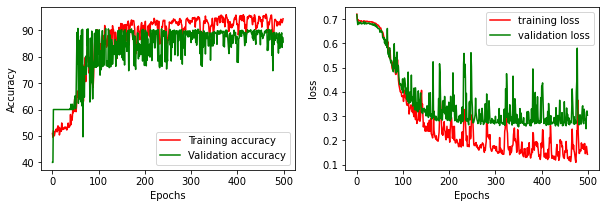

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].plot(np.array(acc_train)*100, color="r", label="Training accuracy")
ax[0].plot(np.array(acc_val)*100, color="g", label="Validation accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(loss, label="training loss", color="r")
ax[1].plot(val_loss, label="validation loss", color="g")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("loss")


Now we can move onto trying the MLTSA for this ML model. For that we call the MLTSA() method within the tensorflow package.


In [46]:
from MLTSA_tensorflow.MLTSA_tf import MLTSA

a_drop = MLTSA_sk(data[:,:,time_frame[0]:time_frame[1]], ans, MLP)

KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy (%)')

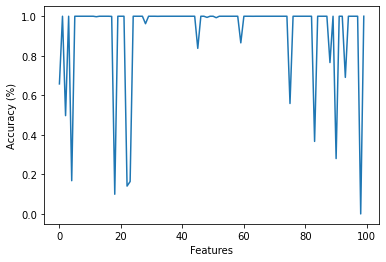

In [45]:
plt.plot(np.mean(a_drop, axis=0));
plt.xlabel("Features")
plt.ylabel("Accuracy (%)")

We call the MLTSA_Plot function to visualize if the Neural Network detects the important features. 

C:\Users\k1802891\Anaconda3\lib\site-packages\MLTSA_sklearn\MLTSA_sk.py:100: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(dat, "-o", color="black", marker="s")


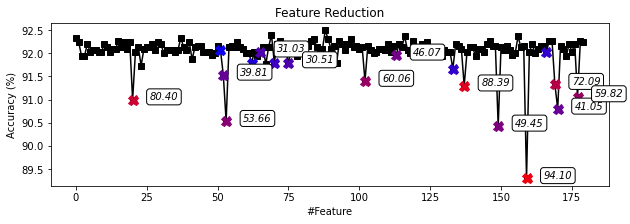

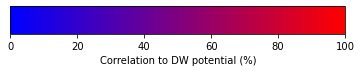

In [30]:
from MLTSA_sklearn.MLTSA_sk import MLTSA_Plot

MLTSA_Plot(a_drop.T, oneD_dataset, pots, errorbar=False)